Imports

In [1]:
import math
import numpy as np
import tensorflow
from tensorflow.keras.datasets import mnist, cifar10, fashion_mnist, cifar100

In [2]:
from tensorflow.keras.utils import to_categorical

Load Fashion-MNIST Data

In [3]:
(training_data,training_labels),(testing_data,testing_labels) = fashion_mnist.load_data()
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


Use 25% of data for hyper-parameter tuning

In [4]:
training_data = training_data[:15000,:,:]
training_labels = training_labels[:15000]
testing_data = testing_data[:2500,:,:]
testing_labels = testing_labels[:2500]
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(15000, 28, 28) (15000,) (2500, 28, 28) (2500,)


In [5]:
training_data = training_data.reshape((training_data.shape[0],28,28,1))
testing_data = testing_data.reshape((testing_data.shape[0],28,28,1))
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(15000, 28, 28, 1) (15000,) (2500, 28, 28, 1) (2500,)


Pre-processing

In [6]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [7]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

In [8]:
from tensorflow.keras.utils import to_categorical

nclasses = 10

# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

Dividing the training data to get validation set

In [9]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(13500, 28, 28, 1) (1500, 28, 28, 1) (13500, 10) (1500, 10)


Implementation of AlexNet Architecture

In [17]:
from tensorflow.keras.layers import Dense, Conv2D, Input, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

class VGG16:

    def __init__(self, nclasses=10) -> None:
       
        self.input_layer = Input(shape=(training_data.shape[1],training_data.shape[2],training_data.shape[3]))

        self.convolution_1_layer = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.input_layer)
        self.convolution_2_layer = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.convolution_1_layer)
        self.maxpool_1_layer = MaxPool2D(pool_size=(3,3), strides=2, padding='same')(self.convolution_2_layer)
        
        self.convolution_3_layer = Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.maxpool_1_layer)
        self.convolution_4_layer = Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.convolution_3_layer)
        self.maxpool_2_layer = MaxPool2D(pool_size=(3,3), strides=2, padding='same')(self.convolution_4_layer)
        
        self.convolution_5_layer = Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.maxpool_2_layer)
        self.convolution_6_layer = Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.convolution_5_layer)
        self.convolution_7_layer = Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.convolution_6_layer)
        self.maxpool_3_layer = MaxPool2D(pool_size=(3,3), strides=2, padding='same')(self.convolution_7_layer)
        
        self.convolution_8_layer = Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.maxpool_3_layer)
        self.convolution_9_layer = Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.convolution_8_layer)
        self.convolution_10_layer = Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.convolution_9_layer)
        self.maxpool_4_layer = MaxPool2D(pool_size=(3,3), strides=2, padding='same')(self.convolution_10_layer)
        
        self.convolution_11_layer = Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.maxpool_4_layer)
        self.convolution_12_layer = Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.convolution_11_layer)
        self.convolution_13_layer = Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.convolution_12_layer)
        self.maxpool_5_layer = MaxPool2D(pool_size=(3,3), strides=2, padding='same')(self.convolution_13_layer)
        
        self.fc_1_layer = Flatten()(self.maxpool_5_layer)
        self.fc_1_layer = Dense(units=4096, activation='relu')(self.fc_1_layer)
        self.fc_2_layer = Dense(units=4096, activation='relu')(self.fc_1_layer)

        self.output_layer = Dense(units=nclasses, activation='softmax')(self.fc_2_layer)

        self.model = Model(inputs=self.input_layer, outputs=self.output_layer)

In [23]:
model_hpt_epoch = VGG16(nclasses=nclasses).model
model_hpt_epoch.compile(
    optimizer=optimizers.SGD(
        learning_rate=0.01,
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_hpt_epoch.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 14, 14, 128)       147584    
                                                           

In [22]:
batch_size = 256

In [24]:
train_hist = []

In [25]:
hist = model_hpt_epoch.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=50, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/50
53/53 [==============================] - 12s 166ms/step - loss: 2.3026 - accuracy: 0.1007 - val_loss: 2.3026 - val_accuracy: 0.0987
Epoch 2/50
53/53 [==============================] - 5s 100ms/step - loss: 2.3022 - accuracy: 0.1033 - val_loss: 2.3026 - val_accuracy: 0.0987
Epoch 3/50
53/53 [==============================] - 5s 103ms/step - loss: 2.3021 - accuracy: 0.1072 - val_loss: 2.3024 - val_accuracy: 0.0987
Epoch 4/50
53/53 [==============================] - 6s 105ms/step - loss: 2.3018 - accuracy: 0.1107 - val_loss: 2.3021 - val_accuracy: 0.1733
Epoch 5/50
53/53 [==============================] - 5s 103ms/step - loss: 2.3013 - accuracy: 0.1167 - val_loss: 2.3012 - val_accuracy: 0.1133
Epoch 6/50
53/53 [==============================] - 5s 102ms/step - loss: 2.3000 - accuracy: 0.1528 - val_loss: 2.2990 - val_accuracy: 0.0987
Epoch 7/50
53/53 [==============================] - 5s 102ms/step - loss: 2.2960 - accuracy: 0.1118 - val_loss: 2.2909 - val_accuracy: 0.2180
Epoch

In [26]:
import matplotlib.pyplot as plt

def showLossAccPlots2(train_hist):
    
    training_acc = []
    validate_acc = []
    train_losses = []
    validate_losses = []
    
    for th in train_hist:
        train_losses += th.history['loss']
        validate_losses += th.history['val_loss']
        training_acc += th.history['accuracy']
        validate_acc += th.history['val_accuracy']
    
    fig, (ax1, ax2) = plt.subplots(2, 1)

    epochs = range(1, len(training_acc) + 1)

    fig.suptitle('Losses and Accuracies across epochs')

    ax1.plot(epochs, train_losses, 'b', label='Training Loss')
    ax1.plot(epochs, validate_losses, 'r', label='Validation Loss')
    ax1.set_ylabel('Losses')
    ax1.legend()

    ax2.plot(epochs, training_acc, 'b', label='Train accuracy')
    ax2.plot(epochs, validate_acc, 'r', label='Validate accuracy')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('Accuracies')
    ax2.legend()

    plt.show()


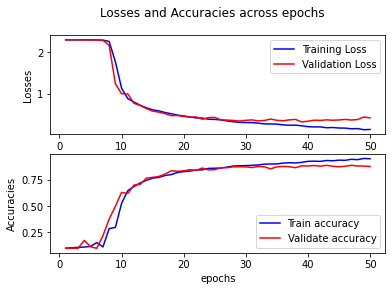

In [27]:
showLossAccPlots2(train_hist)

As we can see, arounds 30 epcohs, validation accuracy peaks and begins to very mildy fluctuate. In fact, training beyond 20 epochs shows no significant increase in performance. Hence, we set the number of epochs = 25.

In [28]:
epochs = 25

In [29]:
learning_rates = [0.001, 0.01, 0.1]

model_hpt_lr0 = VGG16(nclasses=nclasses).model
model_hpt_lr0.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rates[0],
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [30]:
train_hist = []
hist = model_hpt_lr0.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/25
53/53 [==============================] - 6s 98ms/step - loss: 2.3025 - accuracy: 0.1001 - val_loss: 2.3025 - val_accuracy: 0.0987
Epoch 2/25
53/53 [==============================] - 5s 94ms/step - loss: 2.3024 - accuracy: 0.1037 - val_loss: 2.3025 - val_accuracy: 0.0987
Epoch 3/25
53/53 [==============================] - 5s 94ms/step - loss: 2.3023 - accuracy: 0.1037 - val_loss: 2.3025 - val_accuracy: 0.0987
Epoch 4/25
53/53 [==============================] - 5s 97ms/step - loss: 2.3022 - accuracy: 0.1037 - val_loss: 2.3025 - val_accuracy: 0.0987
Epoch 5/25
53/53 [==============================] - 5s 98ms/step - loss: 2.3022 - accuracy: 0.1037 - val_loss: 2.3025 - val_accuracy: 0.0987
Epoch 6/25
53/53 [==============================] - 5s 96ms/step - loss: 2.3022 - accuracy: 0.1037 - val_loss: 2.3025 - val_accuracy: 0.0987
Epoch 7/25
53/53 [==============================] - 5s 97ms/step - loss: 2.3021 - accuracy: 0.1037 - val_loss: 2.3025 - val_accuracy: 0.0987
Epoch 8/25
53

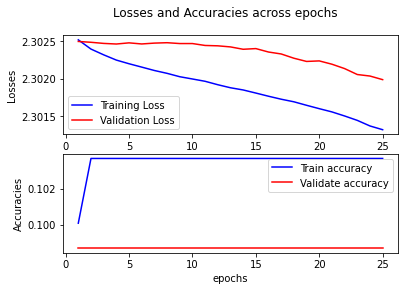

In [31]:
showLossAccPlots2(train_hist)

In [32]:
model_hpt_lr1 = VGG16(nclasses=nclasses).model
model_hpt_lr1.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rates[1],
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [33]:
train_hist = []
hist = model_hpt_lr1.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/25
53/53 [==============================] - 6s 106ms/step - loss: 2.3025 - accuracy: 0.1153 - val_loss: 2.3025 - val_accuracy: 0.0987
Epoch 2/25
53/53 [==============================] - 5s 99ms/step - loss: 2.3021 - accuracy: 0.1067 - val_loss: 2.3025 - val_accuracy: 0.0987
Epoch 3/25
53/53 [==============================] - 5s 100ms/step - loss: 2.3017 - accuracy: 0.1029 - val_loss: 2.3018 - val_accuracy: 0.0987
Epoch 4/25
53/53 [==============================] - 5s 100ms/step - loss: 2.3010 - accuracy: 0.1089 - val_loss: 2.3007 - val_accuracy: 0.1833
Epoch 5/25
53/53 [==============================] - 5s 100ms/step - loss: 2.2990 - accuracy: 0.1536 - val_loss: 2.2970 - val_accuracy: 0.1973
Epoch 6/25
53/53 [==============================] - 5s 103ms/step - loss: 2.2883 - accuracy: 0.2354 - val_loss: 2.2682 - val_accuracy: 0.2813
Epoch 7/25
53/53 [==============================] - 5s 101ms/step - loss: 2.2635 - accuracy: 0.2120 - val_loss: 2.3042 - val_accuracy: 0.0987
Epoch 8

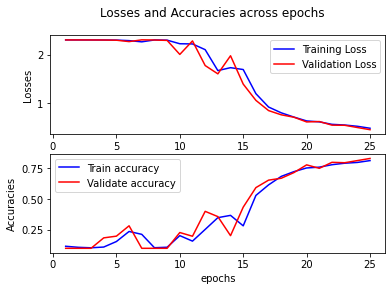

In [34]:
showLossAccPlots2(train_hist)

In [35]:
model_hpt_lr2 = VGG16(nclasses=nclasses).model
model_hpt_lr2.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rates[2],
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [36]:
train_hist = []
hist = model_hpt_lr2.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/25
53/53 [==============================] - 6s 106ms/step - loss: 2.3034 - accuracy: 0.1010 - val_loss: 2.3039 - val_accuracy: 0.0987
Epoch 2/25
53/53 [==============================] - 5s 102ms/step - loss: 2.3260 - accuracy: 0.1324 - val_loss: 2.3052 - val_accuracy: 0.1100
Epoch 3/25
53/53 [==============================] - 5s 100ms/step - loss: 2.3047 - accuracy: 0.1013 - val_loss: 2.3042 - val_accuracy: 0.0987
Epoch 4/25
53/53 [==============================] - 5s 100ms/step - loss: 2.3045 - accuracy: 0.0996 - val_loss: 2.3033 - val_accuracy: 0.1007
Epoch 5/25
53/53 [==============================] - 5s 101ms/step - loss: 2.3042 - accuracy: 0.0953 - val_loss: 2.3034 - val_accuracy: 0.1100
Epoch 6/25
53/53 [==============================] - 5s 99ms/step - loss: 2.3039 - accuracy: 0.0983 - val_loss: 2.3034 - val_accuracy: 0.0967
Epoch 7/25
53/53 [==============================] - 5s 98ms/step - loss: 2.3034 - accuracy: 0.1035 - val_loss: 2.3030 - val_accuracy: 0.0987
Epoch 8/

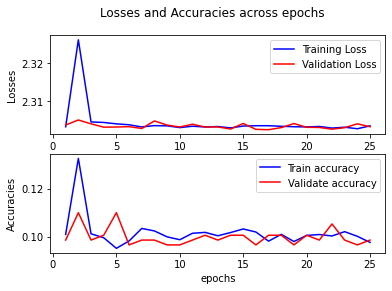

In [37]:
showLossAccPlots2(train_hist)

We can see that lr=0.01 yields the best performance on the validation set, and also fits the training data much better than the rest. In fact, other learning rates yield terrible results. Hence we set learning rate = 0.01

In [38]:
learning_rate = 0.01

In [39]:
momentums = [0.9, 0.75, 0.6]

model_hpt_mt0 = VGG16(nclasses).model
model_hpt_mt0.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentums[0]
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [40]:
train_hist = []
hist = model_hpt_mt0.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/25
53/53 [==============================] - 6s 104ms/step - loss: 2.3025 - accuracy: 0.1014 - val_loss: 2.3026 - val_accuracy: 0.0987
Epoch 2/25
53/53 [==============================] - 5s 100ms/step - loss: 2.3021 - accuracy: 0.1076 - val_loss: 2.3023 - val_accuracy: 0.0987
Epoch 3/25
53/53 [==============================] - 5s 100ms/step - loss: 2.3018 - accuracy: 0.1047 - val_loss: 2.3018 - val_accuracy: 0.0987
Epoch 4/25
53/53 [==============================] - 5s 101ms/step - loss: 2.3010 - accuracy: 0.1199 - val_loss: 2.3009 - val_accuracy: 0.0987
Epoch 5/25
53/53 [==============================] - 5s 102ms/step - loss: 2.2993 - accuracy: 0.1348 - val_loss: 2.2977 - val_accuracy: 0.1827
Epoch 6/25
53/53 [==============================] - 5s 103ms/step - loss: 2.2906 - accuracy: 0.2404 - val_loss: 2.2755 - val_accuracy: 0.2147
Epoch 7/25
53/53 [==============================] - 5s 103ms/step - loss: 2.2556 - accuracy: 0.1821 - val_loss: 2.3045 - val_accuracy: 0.0987
Epoch 

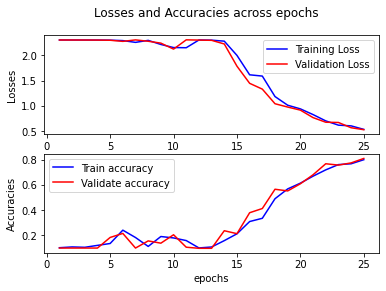

In [41]:
showLossAccPlots2(train_hist)

In [42]:
model_hpt_mt1 = VGG16(nclasses).model
model_hpt_mt1.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentums[1]
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [43]:
train_hist = []
hist = model_hpt_mt1.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/25
53/53 [==============================] - 6s 107ms/step - loss: 2.3025 - accuracy: 0.1050 - val_loss: 2.3024 - val_accuracy: 0.0967
Epoch 2/25
53/53 [==============================] - 5s 103ms/step - loss: 2.3022 - accuracy: 0.1135 - val_loss: 2.3024 - val_accuracy: 0.0987
Epoch 3/25
53/53 [==============================] - 5s 103ms/step - loss: 2.3020 - accuracy: 0.1077 - val_loss: 2.3023 - val_accuracy: 0.2807
Epoch 4/25
53/53 [==============================] - 5s 101ms/step - loss: 2.3018 - accuracy: 0.1339 - val_loss: 2.3021 - val_accuracy: 0.0987
Epoch 5/25
53/53 [==============================] - 5s 103ms/step - loss: 2.3015 - accuracy: 0.1130 - val_loss: 2.3019 - val_accuracy: 0.0987
Epoch 6/25
53/53 [==============================] - 5s 101ms/step - loss: 2.3012 - accuracy: 0.1124 - val_loss: 2.3015 - val_accuracy: 0.0987
Epoch 7/25
53/53 [==============================] - 5s 101ms/step - loss: 2.3007 - accuracy: 0.1355 - val_loss: 2.3009 - val_accuracy: 0.0987
Epoch 

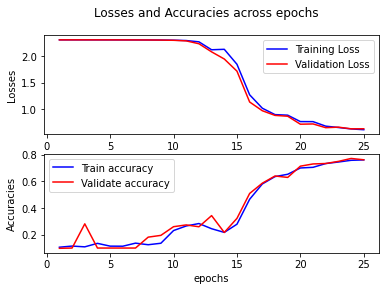

In [44]:
showLossAccPlots2(train_hist)

In [45]:
model_hpt_mt2 = VGG16(nclasses).model
model_hpt_mt2.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentums[2]
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [46]:
train_hist = []
hist = model_hpt_mt2.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/25
53/53 [==============================] - 6s 107ms/step - loss: 2.3025 - accuracy: 0.1107 - val_loss: 2.3024 - val_accuracy: 0.0987
Epoch 2/25
53/53 [==============================] - 5s 100ms/step - loss: 2.3022 - accuracy: 0.1108 - val_loss: 2.3024 - val_accuracy: 0.1013
Epoch 3/25
53/53 [==============================] - 5s 100ms/step - loss: 2.3021 - accuracy: 0.1047 - val_loss: 2.3024 - val_accuracy: 0.0987
Epoch 4/25
53/53 [==============================] - 5s 101ms/step - loss: 2.3020 - accuracy: 0.1079 - val_loss: 2.3024 - val_accuracy: 0.0987
Epoch 5/25
53/53 [==============================] - 5s 101ms/step - loss: 2.3018 - accuracy: 0.1037 - val_loss: 2.3023 - val_accuracy: 0.0987
Epoch 6/25
53/53 [==============================] - 5s 101ms/step - loss: 2.3017 - accuracy: 0.1238 - val_loss: 2.3022 - val_accuracy: 0.0987
Epoch 7/25
53/53 [==============================] - 5s 101ms/step - loss: 2.3016 - accuracy: 0.1037 - val_loss: 2.3021 - val_accuracy: 0.0987
Epoch 

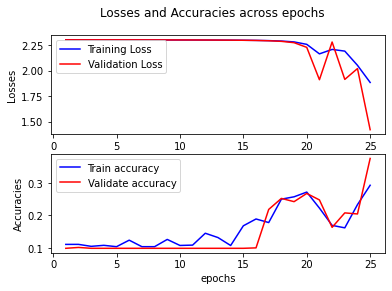

In [47]:
showLossAccPlots2(train_hist)

Here we see that the validation accuracy is slightly higher for momentum value of 0.9 compared to 0.75 and so we will set it accordingly.

In [49]:
momentum = 0.9

MNIST Dataset

In [50]:
(training_data,training_labels),(testing_data,testing_labels) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [51]:
training_data = training_data.reshape((training_data.shape[0],28,28,1))
training_labels = training_labels[:, np.newaxis]
testing_data = testing_data.reshape((testing_data.shape[0],28,28,1))
testing_labels = testing_labels[:, np.newaxis]
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(60000, 28, 28, 1) (60000, 1) (10000, 28, 28, 1) (10000, 1)


In [52]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [53]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

nclasses = len(np.unique(training_labels))

In [54]:
# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

In [55]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (54000, 10) (6000, 10)


In [58]:
model_vgg16_mnist = VGG16().model
model_vgg16_mnist.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_vgg16_mnist.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_130 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_131 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_132 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 conv2d_133 (Conv2D)         (None, 14, 14, 128)       147584    
                                                          

In [59]:
train_hist = []
hist = model_vgg16_mnist.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/25
211/211 [==============================] - 22s 100ms/step - loss: 2.3014 - accuracy: 0.1116 - val_loss: 2.3007 - val_accuracy: 0.1118
Epoch 2/25
211/211 [==============================] - 21s 101ms/step - loss: 2.2998 - accuracy: 0.1124 - val_loss: 2.2963 - val_accuracy: 0.1118
Epoch 3/25
211/211 [==============================] - 21s 100ms/step - loss: 2.1449 - accuracy: 0.2036 - val_loss: 1.7198 - val_accuracy: 0.3193
Epoch 4/25
211/211 [==============================] - 21s 101ms/step - loss: 1.2886 - accuracy: 0.4999 - val_loss: 0.8871 - val_accuracy: 0.6975
Epoch 5/25
211/211 [==============================] - 21s 101ms/step - loss: 0.3354 - accuracy: 0.8859 - val_loss: 0.1508 - val_accuracy: 0.9592
Epoch 6/25
211/211 [==============================] - 21s 101ms/step - loss: 0.0919 - accuracy: 0.9738 - val_loss: 0.0668 - val_accuracy: 0.9827
Epoch 7/25
211/211 [==============================] - 21s 101ms/step - loss: 0.0557 - accuracy: 0.9845 - val_loss: 0.0562 - val_ac

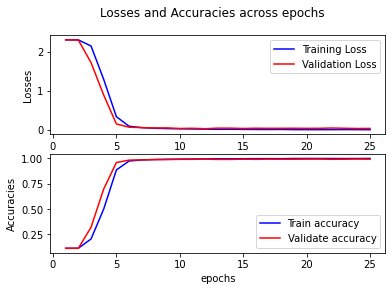

In [60]:
showLossAccPlots2(train_hist)

In [61]:
# Save the model
model_vgg16_mnist.save('VGG16Mnist.h5')

In [62]:
model_vgg16_mnist.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=batch_size,verbose=1)

40/40 [==============================] - 1s 31ms/step - loss: 0.0313 - accuracy: 0.9936


[0.03132624179124832, 0.9936000108718872]

Fashion-MNIST Dataset

In [63]:
(training_data,training_labels),(testing_data,testing_labels) = fashion_mnist.load_data()

In [64]:
training_data = training_data.reshape((training_data.shape[0],28,28,1))
testing_data = testing_data.reshape((testing_data.shape[0],28,28,1))
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [65]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [66]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

nclasses = len(np.unique(training_labels))

In [67]:
# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

In [68]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (54000, 10) (6000, 10)


In [69]:
model_vgg16_fashion_mnist = VGG16().model
model_vgg16_fashion_mnist.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_vgg16_fashion_mnist.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_143 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 conv2d_144 (Conv2D)         (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_145 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 conv2d_146 (Conv2D)         (None, 14, 14, 128)       147584    
                                                          

In [70]:
train_hist = []
hist = model_vgg16_fashion_mnist.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/25
211/211 [==============================] - 22s 102ms/step - loss: 2.3021 - accuracy: 0.1082 - val_loss: 2.3008 - val_accuracy: 0.1700
Epoch 2/25
211/211 [==============================] - 22s 102ms/step - loss: 2.2753 - accuracy: 0.2060 - val_loss: 2.3050 - val_accuracy: 0.0992
Epoch 3/25
211/211 [==============================] - 21s 99ms/step - loss: 2.1013 - accuracy: 0.1907 - val_loss: 1.6380 - val_accuracy: 0.2817
Epoch 4/25
211/211 [==============================] - 21s 99ms/step - loss: 1.4314 - accuracy: 0.3592 - val_loss: 1.2024 - val_accuracy: 0.5418
Epoch 5/25
211/211 [==============================] - 21s 99ms/step - loss: 1.0646 - accuracy: 0.5657 - val_loss: 0.7567 - val_accuracy: 0.7000
Epoch 6/25
211/211 [==============================] - 21s 100ms/step - loss: 0.6818 - accuracy: 0.7358 - val_loss: 1.1653 - val_accuracy: 0.6085
Epoch 7/25
211/211 [==============================] - 21s 100ms/step - loss: 0.5174 - accuracy: 0.8071 - val_loss: 0.4282 - val_accur

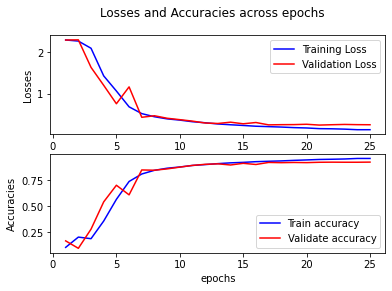

In [71]:
showLossAccPlots2(train_hist)

In [72]:
# Save the model
model_vgg16_fashion_mnist.save('VGG16FashionMnist.h5')

In [73]:
model_vgg16_fashion_mnist.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=batch_size,verbose=1)

40/40 [==============================] - 2s 32ms/step - loss: 0.2567 - accuracy: 0.9216


[0.25671544671058655, 0.9215999841690063]

CIFAR-100 Dataset

In [74]:
(training_data,training_labels),(testing_data,testing_labels) = cifar100.load_data()

169001437/169001437 [==============================] - 14s 0us/step


In [75]:
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [76]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [77]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

nclasses = len(np.unique(training_labels))

In [78]:
# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

In [79]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (45000, 100) (5000, 100)


In [80]:
model_vgg16_cifar100 = VGG16(nclasses=100).model
model_vgg16_cifar100.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_vgg16_cifar100.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_156 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 conv2d_157 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_158 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 conv2d_159 (Conv2D)         (None, 16, 16, 128)       147584    
                                                          

In [81]:
train_hist = []
hist = model_vgg16_cifar100.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/25
176/176 [==============================] - 24s 128ms/step - loss: 4.6054 - accuracy: 0.0090 - val_loss: 4.6055 - val_accuracy: 0.0068
Epoch 2/25
176/176 [==============================] - 19s 108ms/step - loss: 4.6053 - accuracy: 0.0096 - val_loss: 4.6059 - val_accuracy: 0.0068
Epoch 3/25
176/176 [==============================] - 19s 109ms/step - loss: 4.6053 - accuracy: 0.0100 - val_loss: 4.6061 - val_accuracy: 0.0068
Epoch 4/25
176/176 [==============================] - 19s 109ms/step - loss: 4.6052 - accuracy: 0.0090 - val_loss: 4.6063 - val_accuracy: 0.0076
Epoch 5/25
176/176 [==============================] - 19s 105ms/step - loss: 4.6052 - accuracy: 0.0099 - val_loss: 4.6064 - val_accuracy: 0.0068
Epoch 6/25
176/176 [==============================] - 19s 106ms/step - loss: 4.6051 - accuracy: 0.0102 - val_loss: 4.6064 - val_accuracy: 0.0068
Epoch 7/25
176/176 [==============================] - 19s 106ms/step - loss: 4.6049 - accuracy: 0.0104 - val_loss: 4.6062 - val_ac

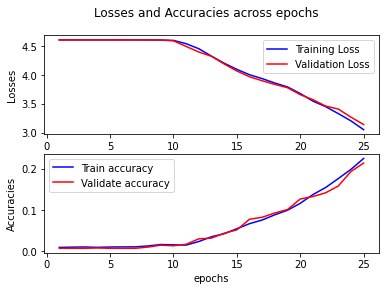

In [82]:
showLossAccPlots2(train_hist)

In [83]:
# Save the model
model_vgg16_cifar100.save('VGG16Cifar100.h5')

In [84]:
model_vgg16_cifar100.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=128,verbose=1)

79/79 [==============================] - 3s 22ms/step - loss: 3.0917 - accuracy: 0.2293


[3.0916619300842285, 0.22930000722408295]